In [1]:
#library imports
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import joblib
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

C:\Users\aqibs\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download necessary NLTK resources
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aqibs\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aqibs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# File paths
csv_file_path1 = "C:/Users/abhure/Documents/SEM3/Text Analytics/Project/Data/raw data/all-data.csv"
csv_file_path2 = "C:/Users/abhure/Documents/SEM3/Text Analytics/Project/Data/raw data/RoBERTaWeaklyLabelling.csv"

In [4]:
# Load datasets
try:
    df1 = pd.read_csv(csv_file_path1, encoding='utf-8')
except UnicodeDecodeError:
    df1 = pd.read_csv(csv_file_path1, encoding='latin1')

try:
    df2 = pd.read_csv(csv_file_path2, encoding='utf-8')
except UnicodeDecodeError:
    df2 = pd.read_csv(csv_file_path2, encoding='latin1')

In [5]:
# Concatenate dataframes
if set(df1.columns) == set(df2.columns):
    df = pd.concat([df1, df2], ignore_index=True)
else:
    column_mapping = {'news': 'news', 'label': 'label'}
    df2 = df2.rename(columns=column_mapping)
    df = pd.concat([df1, df2], ignore_index=True)

df.dropna(inplace=True)

In [6]:
# Lowercase labels
df['label'] = df['label'].apply(lambda x: x.lower())
df.dropna(inplace=True)

In [7]:
# Preprocessing
stop_words = set(stopwords.words('english'))

In [8]:
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'<.*?>', '', text)    # remove HTML tags
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # remove non-alphabetic characters
    text = text.lower()  # convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # remove stopwords
    return text

df['processed_text'] = df['news'].apply(preprocess_text)

In [9]:
# Label encoding
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

In [10]:
# Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
max_length = 128
sentences = df['processed_text'].values
labels = df['label_encoded'].values
input_ids = []
attention_masks = []

Downloading: 100%|██████████| 232k/232k [00:00<00:00, 3.67MB/s]
C:\Users\aqibs\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\file_download.py:127: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\aqibs\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Downloading: 100%|██████████| 48.0/48.0 [00:00<00:00, 14.9kB/s]
Do

In [11]:
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens=True,
                        max_length=max_length,
                        truncation=True,  # Allow truncation if sequence is longer than max_length
                        padding='max_length',
                        return_attention_mask=True,
                        return_tensors='pt'
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

In [12]:
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels, dtype=torch.long)

In [13]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42, test_size=0.2)

In [14]:
batch_size = 32 # Define the batch size for training. Each batch will contain 32 samples.

# Create a TensorDataset from the input tensors, attention masks, and labels.
# This combines the input data, masks, and labels into a single dataset object.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)

# Create a DataLoader for the training data.
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [15]:
# Create a TensorDataset from the input tensors, attention masks, and labels.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)

# Create a DataLoader for the testing data.
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [16]:
# Load model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_encoder.classes_))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Downloading: 100%|██████████| 268M/268M [00:06<00:00, 40.0MB/s] 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly init

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [17]:
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)

In [18]:
# Training the model with 3 epoches
epochs = 3
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Log training loss
        if step % 10 == 0:
            print(f'Step {step}/{len(train_dataloader)}, Training Loss: {loss.item()}')
        

    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Average training loss: {avg_train_loss}')

Epoch 1/3
Step 0/1914, Training Loss: 1.1092029809951782
Step 10/1914, Training Loss: 0.9997962713241577
Step 20/1914, Training Loss: 0.994818925857544
Step 30/1914, Training Loss: 1.0086325407028198
Step 40/1914, Training Loss: 1.002221703529358
Step 50/1914, Training Loss: 1.0089473724365234
Step 60/1914, Training Loss: 0.9034023284912109
Step 70/1914, Training Loss: 0.9224877953529358
Step 80/1914, Training Loss: 0.7176957130432129
Step 90/1914, Training Loss: 0.782752513885498
Step 100/1914, Training Loss: 0.7267622351646423
Step 110/1914, Training Loss: 0.8555247187614441
Step 120/1914, Training Loss: 0.8057034015655518
Step 130/1914, Training Loss: 0.6767488718032837
Step 140/1914, Training Loss: 0.7080772519111633
Step 150/1914, Training Loss: 0.7695011496543884
Step 160/1914, Training Loss: 0.653903067111969
Step 170/1914, Training Loss: 0.6908942461013794
Step 180/1914, Training Loss: 0.6582615375518799
Step 190/1914, Training Loss: 0.6965706944465637
Step 200/1914, Training L

In [19]:
# Save the model
model_save_path = "distilbert_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to distilbert_model.pth


In [23]:
from scipy.special import softmax

model.eval()
predictions, true_labels = [], []
for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1]}
        outputs = model(**inputs)
        logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = batch[2].to('cpu').numpy()
    predictions.extend(logits)
    true_labels.extend(label_ids)

pred_labels = np.argmax(predictions, axis=1)
pred_probs = softmax(np.array(predictions), axis=1)  # Get probabilities for ROC curve

# Calculate metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')

print(f'Validation Accuracy: {accuracy}')
print(f'Validation Precision: {precision}')
print(f'Validation Recall: {recall}')
print(f'Validation F1 Score: {f1}')

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=label_encoder.classes_))

Validation Accuracy: 0.921097322011757
Validation Precision: 0.9229364564357081
Validation Recall: 0.921097322011757
Validation F1 Score: 0.921540313222363

Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.91      0.88      3491
     neutral       0.94      0.94      0.94      5253
    positive       0.95      0.91      0.93      6566

    accuracy                           0.92     15310
   macro avg       0.91      0.92      0.92     15310
weighted avg       0.92      0.92      0.92     15310



The model performs very well overall, with high precision, recall, and F1-Scores across all classes.

The neutral class has the highest precision and recall, indicating that the model is particularly good at identifying neutral instances.

The positive class also has high precision and a strong F1-Score, though the recall is slightly lower.

The negative class has the lowest precision but still performs well in terms of recall and F1-Score.

The classification report shows that your model is highly effective across all classes, with an overall accuracy of 92%.

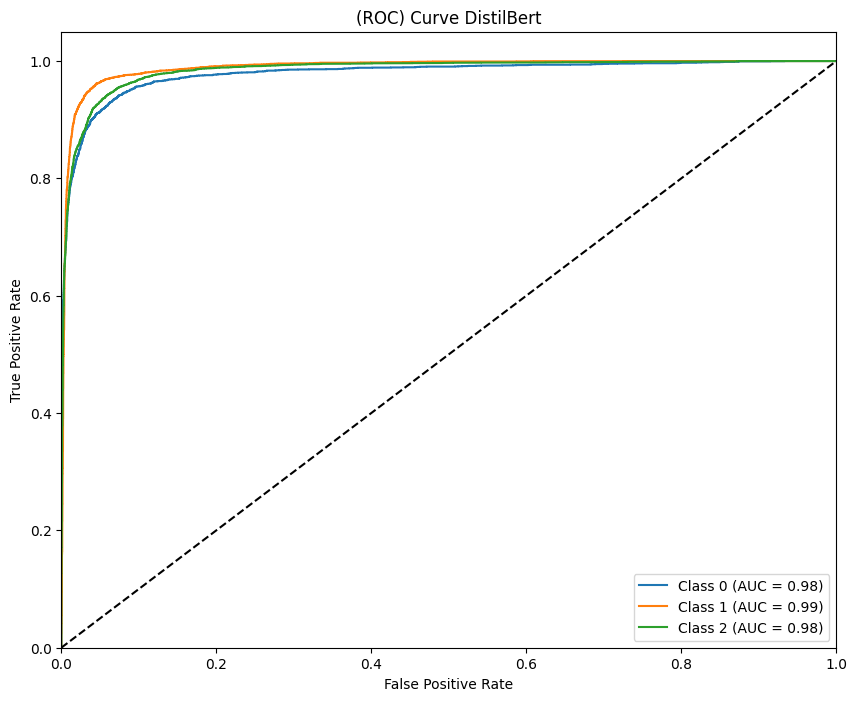

In [24]:
# ROC Curve
num_classes = len(label_encoder.classes_)
true_labels_bin = np.eye(num_classes)[true_labels]

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_labels_bin[:, i], pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve DistilBert')
plt.legend(loc='lower right')
plt.show()

The provided ROC curve for DistilBert demonstrates exceptionally strong performance. All three classes have AUC scores very close to 1.0, indicating excellent discrimination between positive and negative classes. The curves are tightly clustered near the top-left corner of the plot, which is ideal. This suggests that the model can achieve high true positive rates with minimal false positives.